-----Checking for null values for each attribute-----
 Weekday of incident                                      0
Shift                                                    0
Hospital department or location of incident              0
Type of injury incurred, if any                          0
Presence of companion at time of incident                0
Location or environment in which the incident ocurred    0
Fall risk level                                          0
Reason for incident                                      0
Whether a fall prevention protocol was implemented       0
Involvement of medication associated with fall risk      0
Sex                                                      0
Age range                                                0
dtype: int64

-----Printing first 5 samples of the clean inconsistency dataset-----
   Weekday of incident      Shift Hospital department or location of incident  \
0              monday  afternoon                          diagnostic sup

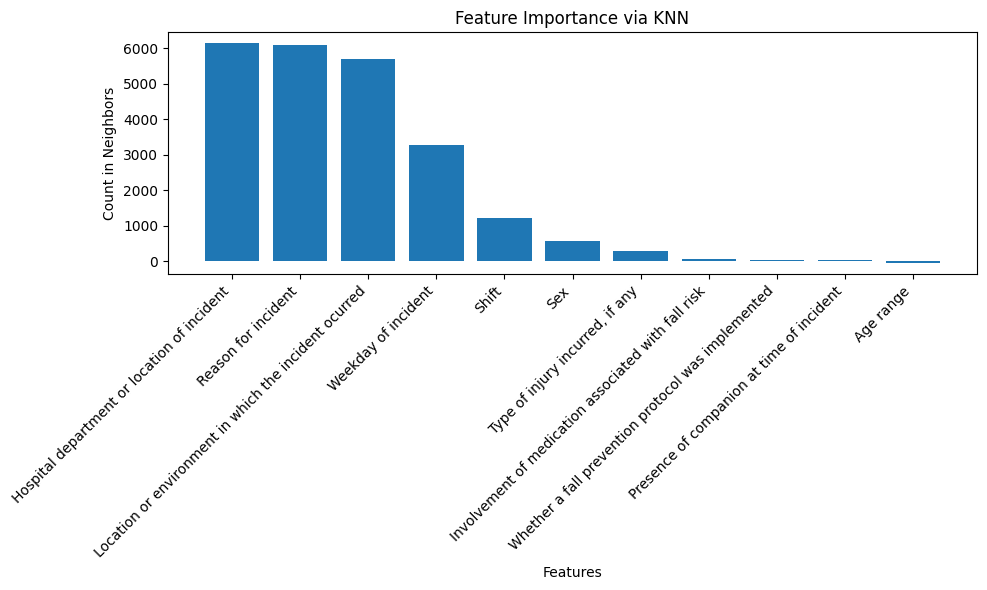

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# file path here
df = pd.read_csv('C:\\Users\\Alexi\\OneDrive\\Desktop\\Machine Learning\\Project\\FallRiskDataSet.csv')

# Dropped rows with any missing values in any column
df.dropna(inplace=True)

# Dropped columns
df = df.drop(columns=['Number', 'Year', 'Date of incident', 'Severity of incident'])

# get attribute which values that contain '/' or ',' 
contains_slash = df['Presence of companion at time of incident'].str.contains('/')
contains_comma = df['Presence of companion at time of incident'].str.contains(',')

# Standardized 'Presence of companion at the time of incident'
df.loc[contains_slash | contains_comma, 'Presence of companion at time of incident'] = 'yes'

misspelled_mapping = {
    'inpatint units': 'inpatient units',
    'emergency department': 'emergency depart',
    'ob&gyn/birth': 'ob&gynbirth',
    'ob&gyb/birth': 'ob&gynbirth',
    'adult icu': 'adult acu',
    'adult acu': 'adult aci',
    'excotiation': 'excoriation',
    'exam rom': 'exam room',
    'surgical prep adverse event': 'surgical prep aradverse event',
    'deficit motor': 'motor deficit',
    'seious adverse event': 'serious adverse event',
    'female': 'f',
    'male': 'm'
}

# fix inconsistencies
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.lower()
        df[col] = df[col].str.strip()
        for misspelled, correct in misspelled_mapping.items():
            df[col] = df[col].str.replace(misspelled, correct)

# Convert "Age range" column to categories and then codes
df['Age range'] = pd.Categorical(df['Age range of patient'], categories=df['Age range of patient'].unique()).codes

# Dropping original "Age range of patient" column
df.drop(columns=['Age range of patient'], inplace=True)

# Convert all values of attributes with yes and no 
for col in df.columns:
    if df[col].dtype == 'object':
        # (Yes: 1, No: 0)
        if any(df[col].isin(['yes', 'no'])):
            df[col] = df[col].map({'yes': 1, 'no': 0})
        # df[col] = df[col].astype('category').cat.codes
            
    # check values for column are unique (no inconsistencies)
    # print(f'Unique values for Attribute: {col}\n', df[col].unique())
    # print('\n')


# injury occured is new label. mapping 'no injury' to 'no' and any other value to 'yes'
df['Type of injury incurred, if any'] = df['Type of injury incurred, if any'].apply(lambda x: 'no' if x == 'no injury' else 'yes')

# check there are no null values
print('-----Checking for null values for each attribute-----\n', df.isnull().sum())

# debug print for 1st 5 samples
print('\n-----Printing first 5 samples of the clean inconsistency dataset-----\n', df.head())

# send clean data to new csv file
# df.to_csv('cleaned_data.csv', index=False)

# Load the cleaned data
# df = pd.read_csv('cleaned_data.csv')

# the target variable
X = df.drop(columns=['Fall risk level'])

# Target variable
y = df['Fall risk level']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=41)

# This function normalizes a feature (column) of a dataset.
# Normalize a feature (column) of a dataset
def normalize_feature(data, feature):
    # encode sring values
    if data[feature].dtype == 'object':
        label_encoder = LabelEncoder()
        data[feature] = label_encoder.fit_transform(data[feature])
    else: # scale values
        scaler = StandardScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
    return data


# Calculates Euclidean distance between two datapoints
def euclidean_distance(dp1, dp2):
    dp1 = np.array(dp1, dtype=float)
    dp2 = np.array(dp2, dtype=float)
    return np.sqrt(np.sum((dp1 - dp2) ** 2))


#lib for plotting
import matplotlib.pyplot as plt

# starting a counter for feature counts
feature_counts = Counter()

# get the k nearest neighbors for a new datapoint
# used to get variable importance by counting the frequency of features
# among K-nearest neighbors for each dp
def get_neighbors(X_train, new_dp, k):
    distances = []
    for i, dp in enumerate(X_train):
        dist = euclidean_distance(new_dp, dp)
        distances.append((i, dist))  # Store index along with distance
    distances.sort(key=lambda x: x[1])
    # indices of k nearest neighbors
    neighbor_indices = [index for index, _ in distances[:k]]
    return neighbor_indices

# determining the class label for the current datapoint
def predict_dp(neighbors_indices, y_train):
    class_counter = Counter()
    for index in neighbors_indices:
        class_label = y_train[index]
        class_counter[class_label] += 1
    prediction = class_counter.most_common(1)[0][0]
    return prediction                     

# normalizing the features before doing operations
for feature in X.columns:
    X_train = normalize_feature(X_train, feature)
    X_test = normalize_feature(X_test, feature)
    
# predicting the class labels of the test set with k = 3
k = 3
predictions = []
for datapoint in X_test.values:
    neighbors = get_neighbors(X_train.values, datapoint, k)
    prediction = predict_dp(neighbors, y_train.values.ravel())
    predictions.append(prediction)

# calculating and printing the accuracy of predictions
correct = sum([y_true == y_pred for y_true, y_pred in zip(y_test.values.ravel(), predictions)])
accuracy = (correct / len(y_test)) * 100
print(f"\nModel Accuracy: {accuracy:.2f}%\n\n")


#--- plo ---
print(f"Variable Importance Plot\n")

# initializing feature_counts
feature_counts = Counter()

# updating feature_counts using neighbor indices

#loop though each data point in test set
for datapoint in X_test.values:
    # get indices of the 3 k-nearest neighbors for current data point within training set
    neighbors_indices = get_neighbors(X_train.values, datapoint, k)
    # go through each 3 nearest neighbors for a datapoint
    for index in neighbors_indices:
        # over each feature in the train set
        for feature in X_train.columns:
            # add value of current neighbor to the count
            # contains the sum of the values of the 3 k-nearest neighbors from each feature for all dps 
            feature_counts[feature] += X_train.iloc[index][feature]

# sorting feats by importance
# feat and its count mappping
# sort by count in descending
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

# creating plot
plt.figure(figsize=(10, 6))
features, counts = zip(*sorted_features)
plt.bar(features, counts)
plt.xlabel('Features')
plt.ylabel('Count in Neighbors')
plt.title('Feature Importance via KNN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# new DataFrame with original test data and predictions
results_df = pd.DataFrame()
# set the values of actual and predicted fall risk levels to dataframe
results_df['Actual Fall Risk Level'] = y_test.values.ravel()
results_df['Predicted Fall Risk Level'] = predictions

# label actual and predictions (20 samples)
# print(results_df.head(20))

print("\n\n\n")




Random Forest Accuracy: 66.31%
Age range: 0.13665911716099946
Whether a fall prevention protocol was implemented: 0.07486553501542499
Weekday of incident: 0.07552224123598338
Reason for incident: 0.03652879200205745
Location or environment in which the incident ocurred: 0.037008224209420605
Hospital department or location of incident: 0.08070888257464981
Shift: 0.12329810903243102
Involvement of medication associated with fall risk: 0.1652659998148557
Sex: 0.04896955412215813
Presence of companion at time of incident: 0.04303216239502869
Type of injury incurred, if any: 0.1781413824369908
1.0


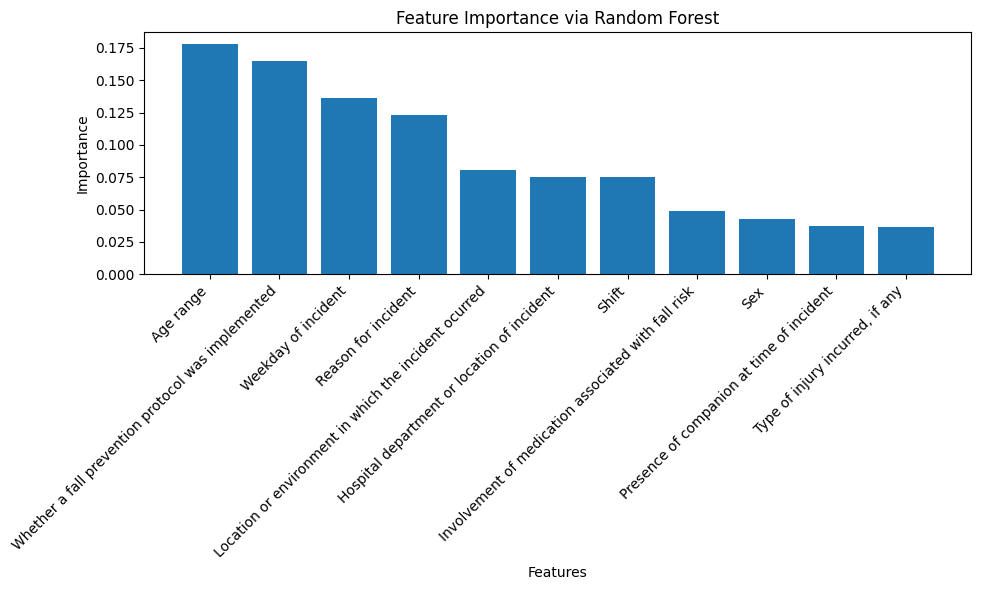

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
rf_predictions = rf_classifier.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

# Get feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names based on feature importances
names = [X.columns[i] for i in indices]

total =0
# Print feature names and their importance values
for name, importance in zip(names, importances):
    print(f"{name}: {importance}")
    total +=importance

print(total)

# Create plot
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance via Random Forest')
plt.tight_layout()
plt.show()